## Import data
 
Importing Amazon(AMZN) data from 01-Jan-2014 to 01-Oct-2019. The data is imported from yahoo finance.

In [30]:
# Import pandas
import pandas as pd

# Import yfinance
import yfinance as yf

# Import data from yahoo finance
data = yf.download(tickers='AMZN', start='2014-01-01', end='2019-10-01')

# Drop the NaN values
data = data.dropna()
data.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,394.58,398.83,393.80,398.79,398.79,1996500
2014-01-02,398.80,399.36,394.02,397.97,397.97,2137800
2014-01-03,398.29,402.71,396.22,396.44,396.44,2210200
2014-01-06,395.85,397.00,388.42,393.63,393.63,3170600
2014-01-07,395.04,398.47,394.29,398.03,398.03,1916000


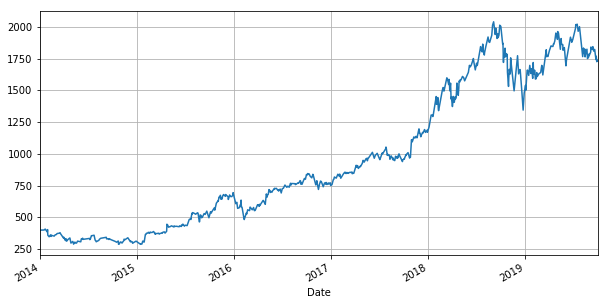

In [31]:
# Import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('fast')

# Plot the closing price
data.Close.plot(figsize=(10,5))
plt.grid()
plt.show()

## Parabolic SAR

Using `SAR`function from Ta-Lib library to calculate the parabolic. The input parameters are high price, low price, acceleration factor (AF), and maximum step.  

As already discussed acceleration factor increases by 0.02 each time the extreme point makes a new high/low and it can reach a maximum of 0.2, no matter how long the uptrend/downtrend extends.


In [32]:
# Import talib
import talib

# Calculate parabolic sar
data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.02, maximum=0.2)

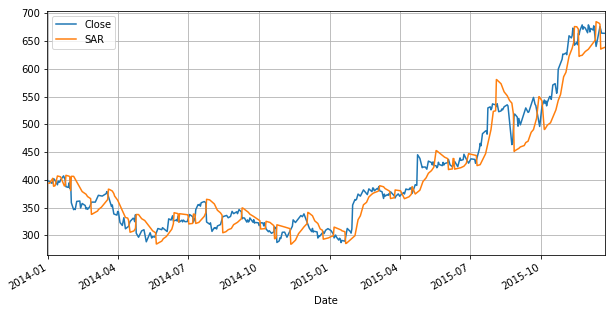

In [33]:
# Plot Parabolic SAR with close price
data[['Close', 'SAR']][:500].plot(figsize=(10,5))
plt.grid()
plt.show()

# Ichimoku Cloud

The Ichimoku Cloud, also known as Ichimoku Kino Hyo consists of five plots and a cloud. <br>

The default parameters of Ichimoku Cloud are 9, 26, 52, 26. <br>

1. Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2 <br> 
2. Kijun-sen (Base Line): (26-period high + 26-period low)/2 <br>
3. Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2 <br>
4. Senkou Span B (Leading Span B): (52-period high + 52-period low)/2 <br>
5. Chikou Span (Lagging Span): Close plotted 26 days in the past

In [34]:
# Calculate Tenkan-sen
high_9 = data.High.rolling(9).max()
low_9 = data.Low.rolling(9).min() 
data['tenkan_sen_line'] = (high_9 + low_9) /2

# Calculate Kijun-sen
high_26 = data.High.rolling(26).max()
low_26 = data.Low.rolling(26).min()
data['kijun_sen_line'] = (high_26 + low_26) / 2

# Calculate Senkou Span A
data['senkou_spna_A'] = ((data.tenkan_sen_line + data.kijun_sen_line) / 2).shift(26)

# Calculate Senkou Span B
high_52 = data.High.rolling(52).max()
low_52 = data.High.rolling(52).min()
data['senkou_spna_B'] = ((high_52 + low_52) / 2).shift(26)

# Calculate Chikou Span B
data['chikou_span'] = data.Close.shift(-26)

In [35]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,SAR,tenkan_sen_line,kijun_sen_line,senkou_spna_A,senkou_spna_B,chikou_span
Date,,,,,,,,,,,,
2013-12-31,394.58,398.83,393.80,398.79,398.79,1996500,NaN,NaN,NaN,NaN,NaN,361.08
2014-01-02,398.80,399.36,394.02,397.97,397.97,2137800,393.8000,NaN,NaN,NaN,NaN,360.87
2014-01-03,398.29,402.71,396.22,396.44,396.44,2210200,393.9112,NaN,NaN,NaN,NaN,361.79
2014-01-06,395.85,397.00,388.42,393.63,393.63,3170600,402.7100,NaN,NaN,NaN,NaN,349.25
2014-01-07,395.04,398.47,394.29,398.03,398.03,1916000,402.7100,NaN,NaN,NaN,NaN,357.20


## Plot komu Cloud

Komu cloud is a space between Senkou Span A and Senkou Span B. The cloud edges provide potential current and future support and resistance points.

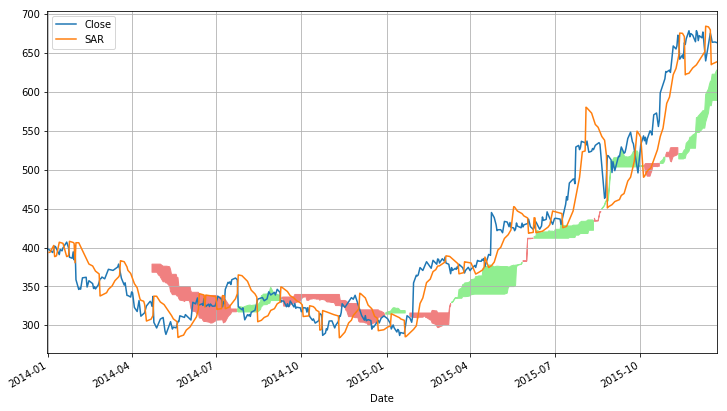

In [36]:
komu_cloud = data[['Close','SAR']][:500].plot(figsize=(12, 7))

komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
                            where=data.senkou_spna_A[:500] >= data.senkou_spna_B[:500], color='lightgreen')

komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
                            where=data.senkou_spna_A[:500] < data.senkou_spna_B[:500], color='lightcoral')
plt.grid()

plt.legend()
plt.show()

## Buy Signal

We will take the buy position when the price is above the Komu cloud and parabolic SAR is below the price.

In [37]:
data['signal'] = 0
data.loc[(data.Close > data.senkou_spna_A) & (data.Close >
                                               data.senkou_spna_B) & (data.Close > data.SAR), 'signal'] = 1

## Sell Signal

We will sell when the price is below the Komu cloud and parabolic SAR is above the price.

In [38]:
data.loc[(data.Close < data.senkou_spna_A) & (data.Close <
                                               data.senkou_spna_B) & (data.Close < data.SAR), 'signal'] = -1

In [39]:
data['signal'].value_counts()

 0    635
 1    613
-1    199
Name: signal, dtype: int64

## Calculate Strategy Returns

We will calculate the strategy returns by multiplying the daily returns with the previous day signal.

In [40]:
# Calculate daily returns
daily_returns = data.Close.pct_change()

# Calculate strategy returns
strategy_returns = daily_returns *data['signal'].shift(1)

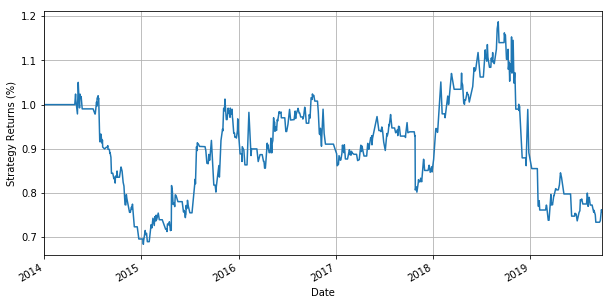

In [41]:
# Calculate cumulative returns 
(strategy_returns+1).cumprod().plot(figsize=(10,5))

# Plot the strategy returns
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.grid()
plt.show()

## Conclusion

This is one simple strategy based on Parabolic SAR and Ichimoku. However it generates a good returns over a period of 5 years. But there are things which you need to take care during backtesting such as stop loss, slippage. Now it’s your turn to tweak the code and make it more close to the live environment.